## Import pacakage

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator

%matplotlib inline

In [2]:
from platform import python_version
print(python_version())

3.6.10


## Load Dataset

In [2]:
data = pd.read_csv('E:/Collection_DS_takehome_challenges/Data/Fraud_Data.csv')
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [4]:
data.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [9]:
ipaddress = pd.read_csv('E:/Collection_DS_takehome_challenges/Data/IpAddress_to_Country.csv')
ipaddress.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [10]:
ipaddress.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lower_bound_ip_address  138846 non-null  float64
 1   upper_bound_ip_address  138846 non-null  int64  
 2   country                 138846 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [11]:
ipaddress['upper_bound_ip_address']=ipaddress['upper_bound_ip_address'].astype(np.float64)

In [12]:
ipaddress.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lower_bound_ip_address  138846 non-null  float64
 1   upper_bound_ip_address  138846 non-null  float64
 2   country                 138846 non-null  object 
dtypes: float64(2), object(1)
memory usage: 3.2+ MB


In [57]:
# check uniquess of tables
print('user_table:\t', len(data['user_id'].unique()))
print('ipaddress:\t', len(ipaddress))

user_table:	 151112
ipaddress:	 138846


## Merge Country to Fraud Data

In [13]:
countries = []
for i in range(len(data)):
    ip_address = data.loc[i, 'ip_address']
    tmp = ipaddress[(ipaddress['lower_bound_ip_address'] <= ip_address) &
                    (ipaddress['upper_bound_ip_address'] >= ip_address)]
    if len(tmp) == 1:
        countries.append(tmp['country'].values[0])
    else:
        countries.append('NA')
        
data['country'] = countries

In [14]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [13]:
# With very low speed, not to use

# from pandasql import sqldf

#q = """
#   SELECT A.*,B.country
#        FROM
#            data A
#        left JOIN
#            ipaddress B
#        ON 
#           A.ip_address <= B.upper_bound_ip_address AND
#          A.ip_address >= B.lower_bound_ip_address;
#   """

#data1=sqldf(q)

In [14]:
for column in data.columns:
    uniques = sorted(data[column].unique())
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:5])

user_id              151112	 [2, 4, 8, 9, 12]
signup_time          151112	 ['2015-01-01 00:00:42', '2015-01-01 00:00:43', '2015-01-01 00:00:44', '2015-01-01 00:00:45', '2015-01-01 00:00:46']
purchase_time        150679	 ['2015-01-01 00:00:44', '2015-01-01 00:00:45', '2015-01-01 00:00:46', '2015-01-01 00:00:47', '2015-01-01 00:00:48']
purchase_value         122	 [9, 10, 11, 12, 13]
device_id            137956	 ['AAALBGNHHVMKG', 'AAAWIHVCQELTP', 'AAAXJHWCLISKY', 'AAAXXOZJRZRAO', 'AABFGRPBQHWFQ']
source                   3	 ['Ads', 'Direct', 'SEO']
browser                  5	 ['Chrome', 'FireFox', 'IE', 'Opera', 'Safari']
sex                      2	 ['F', 'M']
age                     58	 [18, 19, 20, 21, 22]
ip_address           143512	 [52093.4968949854, 93447.13896136609, 105818.501505225, 117566.66486748, 131423.789041531]
class                    2	 [0, 1]
country                182	 ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda']


In [21]:
data.isnull().sum()

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
country           0
dtype: int64

## Exploratory Data Analysis

In [59]:
print('{0:25s} {1:>8.4f}%'.format('Total Fraud percentage:', data['class'].mean() * 100))

Total Fraud percentage:     9.3646%


In [61]:
data[['class','user_id']].groupby('class').count() / len(data)

,user_id
class,
0,0.906354
1,0.093646


In [60]:
# Distribution
data.groupby('source')['user_id'].count() / len(data)

source
0    0.396269
1    0.202605
2    0.401126
Name: user_id, dtype: float64

In [87]:
# Visualization of different source
grouped = data[['source', 'class']].groupby('source').mean().sort_values('class').reset_index()
grouped.head()

,source,class
0,SEO,0.089285
1,Ads,0.092066
2,Direct,0.105370


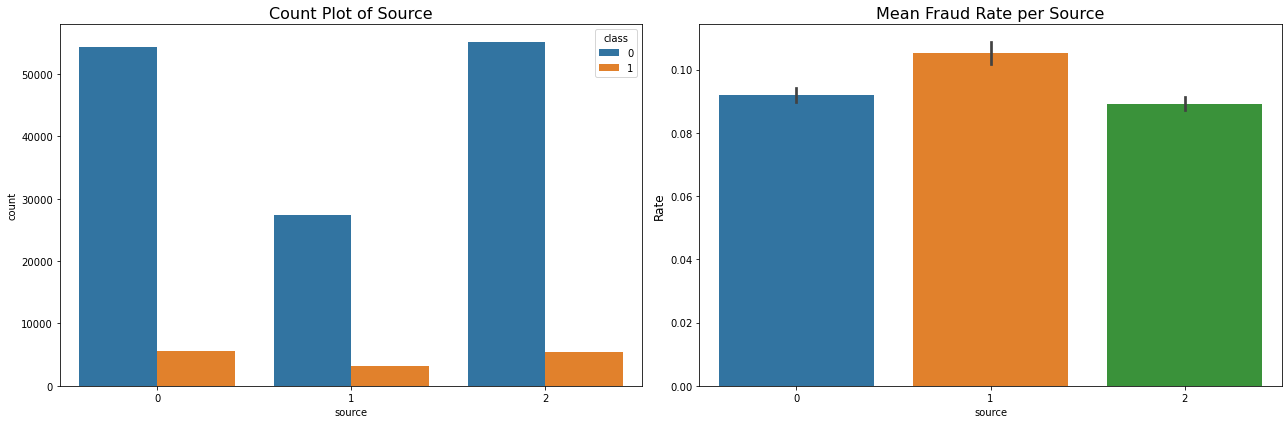

In [62]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='source', hue='class', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Source', fontsize=16)
sns.barplot(x='source', y='class', data=data, ax=ax[1]);
ax[1].set_title('Mean Fraud Rate per Source', fontsize=16)
ax[1].set_ylabel('Rate', fontsize=12)
plt.tight_layout()
plt.show()

In [88]:
# Visualization of different sex
grouped = data[['sex', 'class']].groupby('sex').mean().reset_index()
grouped.head()

,sex,class
0,F,0.091007
1,M,0.095523


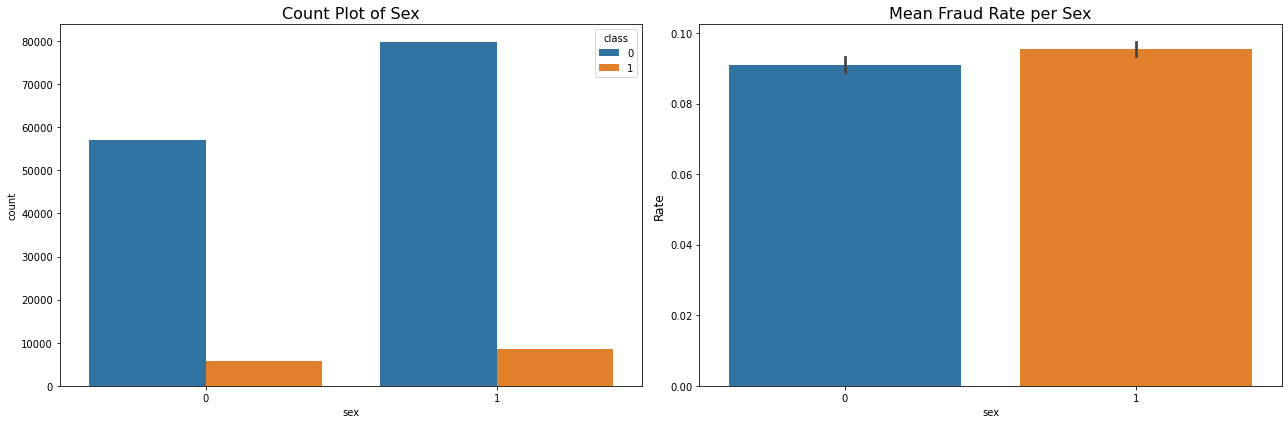

In [63]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='sex', hue='class', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Sex', fontsize=16)
sns.barplot(x='sex', y='class', data=data, ax=ax[1]);
ax[1].set_title('Mean Fraud Rate per Sex', fontsize=16)
ax[1].set_ylabel('Rate', fontsize=12)
plt.tight_layout()
plt.show()

In [91]:
# Visualization of different browser           
grouped = data[['browser', 'class']].groupby('browser').mean().sort_values('class').reset_index()
grouped.head()

,browser,class
0,IE,0.086775
1,Opera,0.089227
2,Safari,0.090201
3,FireFox,0.095165
4,Chrome,0.098792


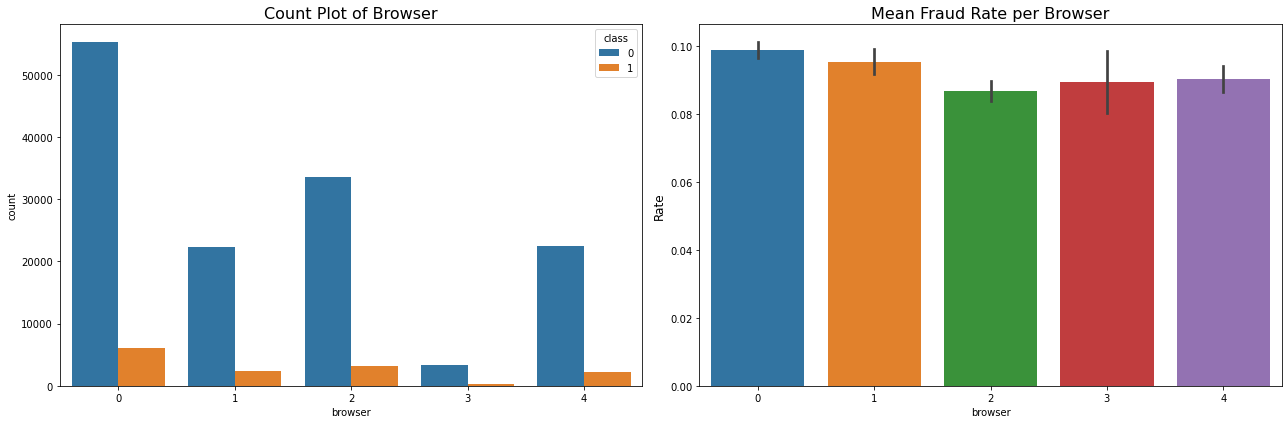

In [64]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='browser', hue='class', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Browser', fontsize=16)
sns.barplot(x='browser', y='class', data=data, ax=ax[1]);
ax[1].set_title('Mean Fraud Rate per Browser', fontsize=16)
ax[1].set_ylabel('Rate', fontsize=12)
plt.tight_layout()
plt.show()

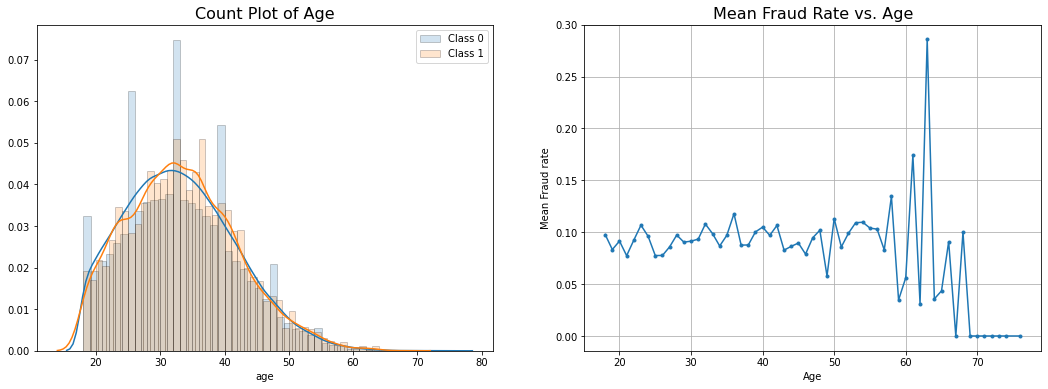

In [28]:
# Visualization of different sources
grouped = data[['age', 'class']].groupby('age').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(data[data['class'] == 0]['age'], label='Class 0', 
             ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['class'] == 1]['age'], label='Class 1', 
             ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Age', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['age'], grouped['class'], '.-')
ax[1].set_title('Mean Fraud Rate vs. Age', fontsize=16)
ax[1].set_xlabel('Age')
ax[1].set_ylabel('Mean Fraud rate')
ax[1].grid(True)
plt.show()

In [93]:
class0=data[data['class']==0]['age']
class0.describe()

count    136961.000000
mean         33.122356
std           8.622678
min          18.000000
25%          27.000000
50%          33.000000
75%          39.000000
max          76.000000
Name: age, dtype: float64

In [94]:
class1=data[data['class']==1]['age']
class1.describe()

count    14151.000000
mean        33.318281
std          8.568001
min         18.000000
25%         27.000000
50%         33.000000
75%         39.000000
max         68.000000
Name: age, dtype: float64

## Create Table for Day, Source and Total # of Fraud

In [29]:
# Define table
unique_date=pd.date_range(start='2015-01-01',end='2015-12-31',freq='D')
unique_source=sorted(data['source'].unique())
print(unique_date[0:6])
print(unique_source)

DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04',
               '2015-01-05', '2015-01-06'],
              dtype='datetime64[ns]', freq='D')
['Ads', 'Direct', 'SEO']


In [30]:
day = []
source = []
fraud = []
for date in unique_date:
    for idx in unique_source:
        total_fraud=len(data[(data['purchase_time']<=date) & (data['source']==idx)])
        day.append(date)
        source.append(idx)
        fraud.append(total_fraud)
        
table=pd.DataFrame({'day':day,'Source':source,'Total Fraud':fraud}, columns=
                  ['day','Source','Total Fraud']) 

In [32]:
table.head(20)

,day,Source,Total Fraud
0,2015-01-01,Ads,0
1,2015-01-01,Direct,0
2,2015-01-01,SEO,0
3,2015-01-02,Ads,234
4,2015-01-02,Direct,133
5,2015-01-02,SEO,204
6,2015-01-03,Ads,545
7,2015-01-03,Direct,312
8,2015-01-03,SEO,450
9,2015-01-04,Ads,720


## Feature Engineering

1. Time difference between sign-up time and purchase time
2. If the device id is unique or certain users are sharing the same device (many different user ids using the same device could be an indicator of fake accounts)
3. Same for the ip address. Many different users having the same ip address could be an indicator of fake accounts
4. Usual week of the year and day of the week from time variables

In [15]:
# Get the time difference between purchase time and signup time
data['purchase_time'] = pd.to_datetime(data['purchase_time'])
data['signup_time'] = pd.to_datetime(data['signup_time'])
time_diff=data['purchase_time']-data['signup_time']
time_diff=time_diff.apply(lambda x :x.seconds)
data['time_diff']=time_diff

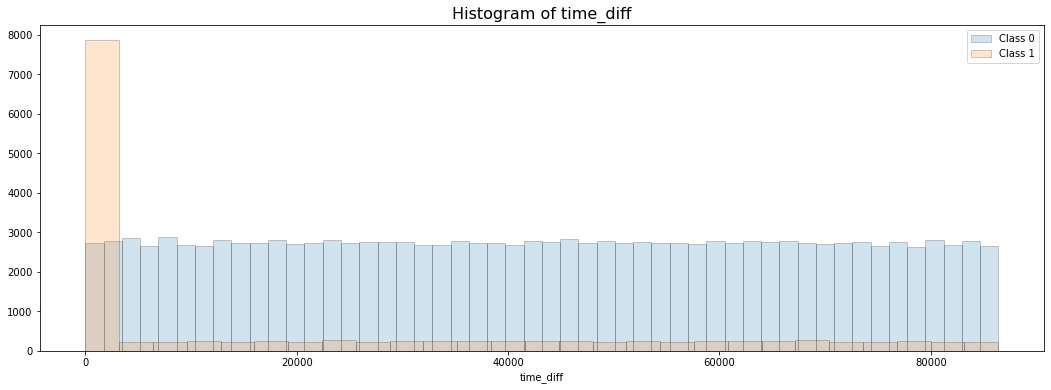

In [43]:
# Visualization of different time_diff
grouped = data[['time_diff', 'class']].groupby('time_diff').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
sns.distplot(data[data['class'] == 0]['time_diff'],kde=False, label='Class 0', 
             ax=ax, hist_kws=hist_kws)
sns.distplot(data[data['class'] == 1]['time_diff'],kde=False, label='Class 1', 
             ax=ax, hist_kws=hist_kws)
ax.set_title('Histogram of time_diff', fontsize=16)
ax.legend()
#ax[1].plot(grouped['time_diff'], grouped['class'], '.-')
#ax[1].set_title('Mean Fraud Rate vs. time_diff', fontsize=16)
#ax[1].set_xlabel('time_diff')
#ax[1].set_ylabel('Mean Fraud rate')
#ax[1].grid(True)
plt.show()

In [70]:
# Get different user number for each unique devices
device_num=data[['user_id','device_id']].groupby('device_id').count().reset_index()
device_num=device_num.rename(columns={'user_id':'users_for_same_device'})
data=data.merge(device_num,how='left',on='device_id')
device_num.sort_values(by='users_for_same_device', ascending=False).head()

,device_id,users_for_same_device
54521,KIPFSCNUGOLDP,20
69916,NGQCKIADMZORL,20
14100,CQTUVBYIWWWBC,20
46203,ITUMJCKWEYNDD,20
24607,EQYVNEGOFLAWK,20


In [65]:
def unique_count(x):
    """ function to count the unique user_id """
    return len(np.unique(x))

In [68]:
different_user_count = data.groupby('device_id')['user_id'].apply(unique_count).reset_index()
different_user_count = different_user_count.rename(columns={'user_id': 'user_count'})
different_user_count = different_user_count.sort_values(by='user_count', ascending=False)
different_user_count.head()

,device_id,user_count
54521,KIPFSCNUGOLDP,20
69916,NGQCKIADMZORL,20
14100,CQTUVBYIWWWBC,20
46203,ITUMJCKWEYNDD,20
24607,EQYVNEGOFLAWK,20


In [17]:
# Get different user number for each unique ip_address
ip_num=data[['user_id','ip_address']].groupby('ip_address').count().reset_index()
ip_num=ip_num.rename(columns={'user_id':'users_for_same_ip'})
data=data.merge(ip_num,how='left',on='ip_address')

In [18]:
## Signup day and week
data['signup_day'] = data['signup_time'].apply(lambda x: x.dayofweek)
data['signup_week'] = data['signup_time'].apply(lambda x: x.week)

# Purchase day and week
data['purchase_day'] = data['purchase_time'].apply(lambda x: x.dayofweek)
data['purchase_week'] = data['purchase_time'].apply(lambda x: x.week)

In [19]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,users_for_same_device,users_for_same_ip,signup_day,signup_week,purchase_day,purchase_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1,1,1,9,5,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1,1,6,23,0,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12,12,3,1,3,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,60085,1,1,1,18,0,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1,1,1,30,2,37


## H2O Random Forest

In [72]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.162-b12, mixed mode)
  Starting server from D:\Anaconda3\envs\py36\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\DELL\AppData\Local\Temp\tmp3v9jsw7t
  JVM stdout: C:\Users\DELL\AppData\Local\Temp\tmp3v9jsw7t\h2o_ALEX_started_from_python.out
  JVM stderr: C:\Users\DELL\AppData\Local\Temp\tmp3v9jsw7t\h2o_ALEX_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,12 secs
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.4
H2O_cluster_version_age:,7 months !!!
H2O_cluster_name:,H2O_from_python_ALEX_zllq8q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.752 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [73]:
# Transform to H2O Frame, and make sure the target variable is categorical
h2o_df = H2OFrame(data)

for name in ['signup_day', 'purchase_day', 'source', 'browser', 'sex', 'country', 'class']:
    h2o_df[name] = h2o_df[name].asfactor()

h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,users_for_same_device,users_for_same_ip,signup_day,signup_week,purchase_day,purchase_week
type,int,time,time,int,string,enum,enum,enum,int,real,enum,enum,int,int,int,enum,int,enum,int
mins,2.0,1420070442000.0,1420070444000.0,9.0,NaN,,,,18.0,52093.4968949854,,,1.0,1.0,1.0,,1.0,,1.0
mean,200171.04096961228,1429491369511.3245,1434423398759.9531,36.93537243898569,NaN,,,,33.14070358409643,2152145330.958829,,,40942.58442744463,1.6843665625496342,1.6027185134205082,,16.5017404309386,,24.65857112605216
maxs,400000.0,1439872829000.0,1450234565000.0,154.0,NaN,,,,76.0,4294850499.67884,,,86399.0,20.0,20.0,,34.0,,51.0
sigma,115369.2850241342,5930618906.324853,7042565812.476391,18.322762148662147,NaN,,,,8.617733490961461,1248497030.1004274,,,26049.661902118325,2.616953602804173,2.5962395273758427,,9.814287461798866,,11.651556782719476
zeros,0,0,0,0,0,,,,0,0,,,0,0,0,,0,,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,22058.0,2015-02-24 22:55:49,2015-04-18 02:47:11,34.0,QVPSPJUOCKZAR,SEO,Chrome,M,39.0,732758368.79972,0,Japan,13882.0,1.0,1.0,1,9.0,5,16.0
1,333320.0,2015-06-07 20:39:50,2015-06-08 01:38:54,16.0,EOGFQPIZPYXFZ,Ads,Chrome,F,53.0,350311387.865908,0,United States,17944.0,1.0,1.0,6,23.0,0,24.0
2,1359.0,2015-01-01 18:52:44,2015-01-01 18:52:45,15.0,YSSKYOSJHPPLJ,SEO,Opera,M,53.0,2621473820.11095,1,United States,1.0,12.0,12.0,3,1.0,3,1.0


In [74]:
# Split into 75% training and 25% test dataset
strat_split=h2o_df['class'].stratified_split(test_frac=0.25,seed=42)

train=h2o_df[strat_split=='train']
test=h2o_df[strat_split=='test']

# Define features and target
feature=['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 'source', 
           'browser', 'sex', 'age', 'country', 'time_diff', 'users_for_same_device', 'users_for_same_ip']
target='class'

In [75]:
model=H2ORandomForestEstimator(balance_classes=True,ntrees=100,max_depth=20,mtries=-1,seed=42,
                              stopping_rounds=5,stopping_metric='auc',score_each_iteration=True)
model.train(x=feature,y=target,training_frame=train,validation_frame=test)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [ ]:
# Not use stop metric and validation
# model=H2ORandomForestEstimator(balance_classes=True,ntrees=100,max_depth=20,mtries=-1,seed=42,
#                              score_each_iteration=True)
# model.train(x=feature,y=target,training_frame=train)

In [76]:
# Can use the codes below for a better visualization
# model.varimp_plot()

In [77]:
# Feature importance
importance = model.varimp(use_pandas=True)
print(importance)

                 variable  relative_importance  scaled_importance  percentage
0   users_for_same_device        181915.312500           1.000000    0.303431
1       users_for_same_ip         99221.484375           0.545427    0.165499
2               time_diff         71643.164062           0.393827    0.119499
3             signup_week         59583.714844           0.327535    0.099384
4           purchase_week         58530.761719           0.321747    0.097628
5                 country         42594.359375           0.234144    0.071047
6          purchase_value         18511.308594           0.101758    0.030876
7                     age         18207.763672           0.100089    0.030370
8              signup_day         17195.029297           0.094522    0.028681
9            purchase_day         13043.959961           0.071703    0.021757
10                browser         10347.096680           0.056879    0.017259
11                 source          5324.669922           0.02927

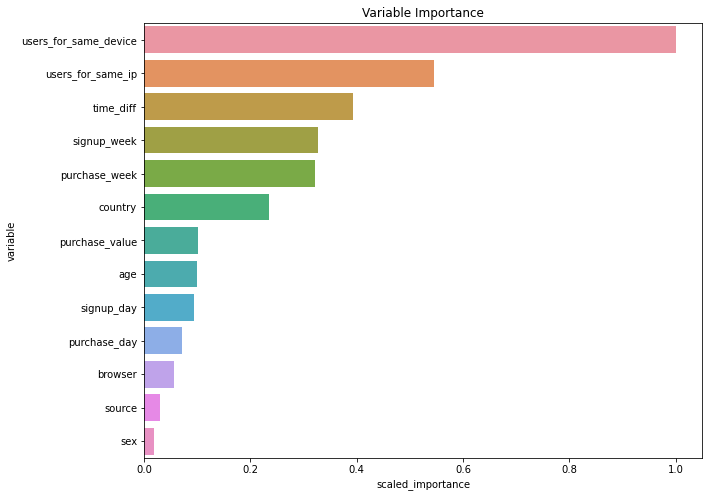

In [78]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.title('Variable Importance')
plt.show()

In [79]:
# Make predictions
train_true=train.as_data_frame()['class'].values # remove index, only keep values as array 
print(train_true)
test_true=test.as_data_frame()['class'].values
train_pred=model.predict(train).as_data_frame()['p1'].values # have 3 columns: predict,p0,p1
test_pred=model.predict(test).as_data_frame()['p1'].values # have 3 columns: predict,p0,p1

train_fpr,train_tpr,_=roc_curve(train_true,train_pred)
test_fpr,test_tpr,_=roc_curve(test_true,test_pred)
train_auc=np.round(auc(train_fpr,train_tpr),3)
test_auc=np.round(auc(test_fpr,test_tpr),3)

[0 0 1 ... 0 0 0]
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [80]:
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     34240
           1       1.00      0.53      0.70      3538

    accuracy                           0.96     37778
   macro avg       0.98      0.77      0.84     37778
weighted avg       0.96      0.96      0.95     37778



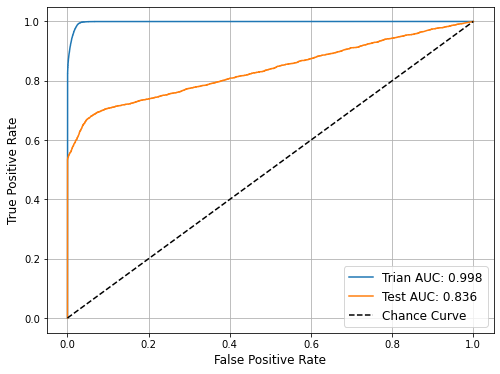

In [81]:
train_fpr = np.insert(train_fpr, 0, 0)
train_tpr = np.insert(train_tpr, 0, 0)
test_fpr = np.insert(test_fpr, 0, 0)
test_tpr = np.insert(test_tpr, 0, 0)

fig,ax=plt.subplots(figsize=(8,6))
ax.plot(train_fpr,train_tpr,label='Trian AUC: '+str(train_auc))
ax.plot(test_fpr,test_tpr,label='Test AUC: '+str(test_auc))
ax.plot(train_fpr, train_fpr, 'k--', label='Chance Curve')
ax.set_xlabel('False Positive Rate',fontsize=12)
ax.set_ylabel('True Positive Rate',fontsize=12)
ax.grid(True)
ax.legend(fontsize=12)
plt.show()

In [ ]:
# Not contain Chance curve
#fig,ax=plt.subplots(figsize=(8,6))
#ax.plot(train_fpr,train_tpr,label='Trian AUC: '+str(train_auc))
#ax.plot(test_fpr,test_tpr,label='Test AUC: '+str(test_auc))
#ax.set_xlabel('False Positive Rate',fontsize=12)
#ax.set_ylabel('True Positive Rate',fontsize=12)
#ax.legend(fontsize=12)
#plt.show()

Based on the ROC, if we care about minimizing false positive, we would choose a cut-off that would give us true positive rate of ~0.5 and false positive rate almost zero (this was essentially the random forest output). However, if we care about maximizing true positive, we will have to decrease the cut-off. This way we will classify more events as “1”: some will be true ones (so true positive goes up) and many, unfortunately, will be false ones (so false positive will also go up).

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


D:\Anaconda3\envs\py36\lib\site-packages\h2o\model\model_base.py:1359: MatplotlibDeprecationWarning: The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.
  axs.fill_between(x, lower, upper, where=lower < upper, alpha=0.1, interpolate=False)


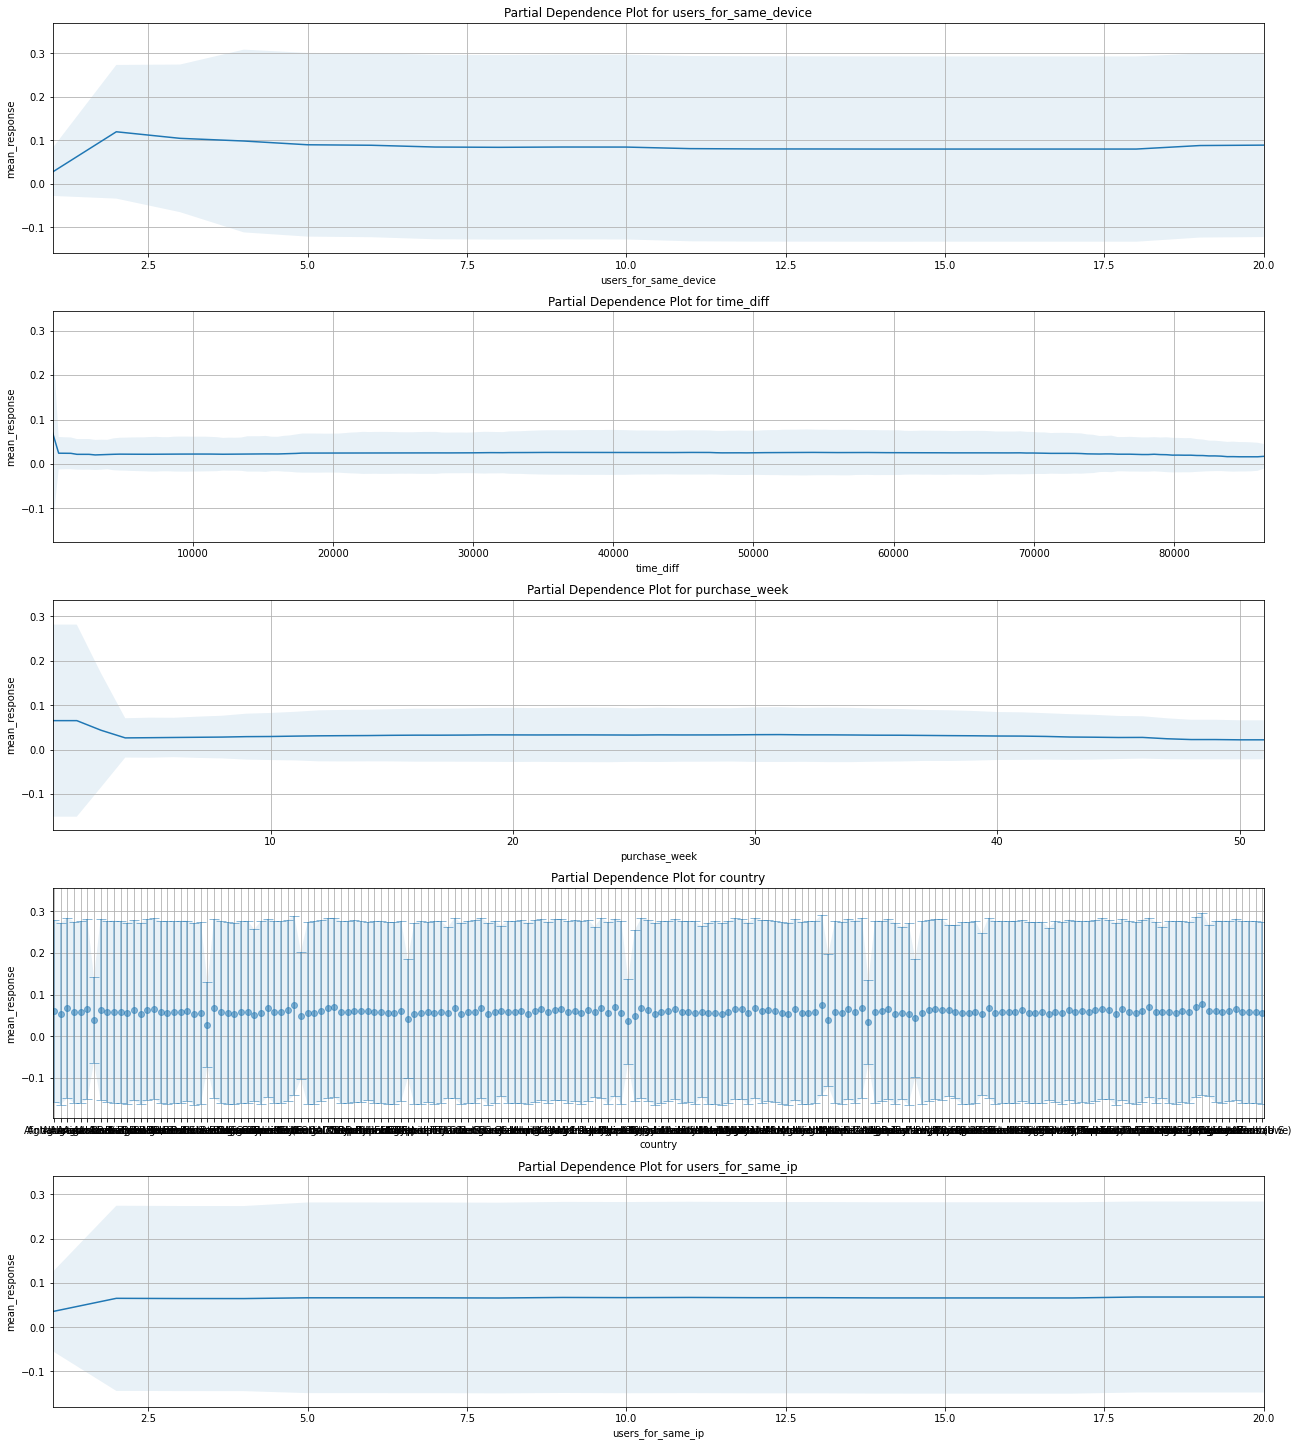

In [82]:
cols = ['users_for_same_device', 'time_diff', 'purchase_week', 'country', 'users_for_same_ip']
_ = model.partial_plot(train, cols=cols,nbins=200, figsize=(18, 20))
# _ = model.partial_plot(train, cols=cols,nbins=200, figsize=(8, 15))

In [67]:
# Shutdown h2o instance
h2o.cluster().shutdown()

H2O session _sid_a2c8 closed.


Regarding “how to use this from a product perspective”: you now have a model that assigns to each user a probability of committing a fraud. You want to think about creating different experiences based on that. For instance:

1. If predicted fraud probability < X, the user has the normal experience (the high majority should fall here)
2. If X <= predicted fraud probability < Z (so the user is at risk, but not too much), you can create an additional verification step, like verify your phone number via a code sent by SMS or log in via Facebook.
3. If predicted fraud probability >= Z (so here is really likely the user is trying to commit a fraud), you can tell the user his session has been put on hold, send this user info to someone who reviews it manually and either blocks the user or decides it is not a fraud so the session is resumed.

This is just an example and there are many different ways to build products around some fraud score. However, it is important because it highlights that a ML model is often really useful when it is combined with a product which is able to take advantage of its strengths and minimize its possible drawbacks (like false positives).

## Additional Analysis - Logistic Regression

In [95]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection  import train_test_split,GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix

In [96]:
feature=['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 'source', 
           'browser', 'sex', 'age', 'country', 'time_diff', 'users_for_same_device', 'users_for_same_ip']
target='class'
x=data[feature]
x=pd.get_dummies(x)# OHE those categorical features
y=data[target]
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.333)
ytrain.mean(),ytest.mean()

(0.09390719409471084, 0.09312215576002067)

In [104]:
lrcv=LogisticRegressionCV(Cs = np.logspace(-3,3,7),
                            dual=False,
                            scoring='roc_auc',
                            max_iter=2000,
                            n_jobs=-1,
                            verbose=1)
lrcv.fit(xtrain,ytrain)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   29.0s remaining:   43.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   33.4s finished


LogisticRegressionCV(Cs=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                     max_iter=2000, n_jobs=-1, scoring='roc_auc', verbose=1)

In [105]:
lrcv.C_

array([10.])

In [106]:
lrcv.scores_

{1: array([[0.77136973, 0.77137016, 0.77136967, 0.77137016, 0.77136967,
         0.77137016, 0.77136967],
        [0.77940805, 0.77940788, 0.77940773, 0.7794079 , 0.77940845,
         0.77940799, 0.77940834],
        [0.79485077, 0.79485074, 0.79485083, 0.79485074, 0.79485083,
         0.79485074, 0.79485077],
        [0.76771276, 0.7677123 , 0.76771294, 0.76771256, 0.76771294,
         0.7677125 , 0.76771294],
        [0.78895911, 0.78895902, 0.78895896, 0.78895911, 0.78895896,
         0.78895911, 0.78895896]])}

In [107]:
lrcv.score(xtrain,ytrain)

0.7810315978613573

In [108]:
lrcv.score(xtest,ytest)

0.7814055149413636

In [109]:
# Classification report
ytest_predict = lrcv.predict(xtest)
print(classification_report(y_true=ytest,y_pred=ytest_predict))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     45635
           1       0.93      0.54      0.68      4686

    accuracy                           0.95     50321
   macro avg       0.94      0.77      0.83     50321
weighted avg       0.95      0.95      0.95     50321



In [112]:
feat_importances=pd.DataFrame({"Variable Name":xtrain.columns,"Coef":lrcv.coef_[0]})
feat_importances['importances'] = np.abs( feat_importances['Coef'] )
feat_importances.sort_values(by="importances",inplace=True,ascending=False)
feat_importances.reset_index(drop=True, inplace=True) # reorder the index with simple sequential numbers
feat_importances.head(10)

,Variable Name,Coef,importances
0,users_for_same_device,0.223129,0.223129
1,users_for_same_ip,0.185698,0.185698
2,purchase_week,-0.063927,0.063927
3,age,-0.042028,0.042028
4,signup_week,0.041431,0.041431
5,signup_day,-0.030834,0.030834
6,purchase_day,-0.029154,0.029154
7,purchase_value,-0.009844,0.009844
8,source_SEO,-0.008049,0.008049
9,source_Ads,-0.006544,0.006544


## Additional Analysis - Decision Tree

In [20]:
import graphviz
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

In [33]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,users_for_same_device,users_for_same_ip,signup_day,signup_week,purchase_day,purchase_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1,1,1,9,5,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1,1,6,23,0,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12,12,3,1,3,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,60085,1,1,1,18,0,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1,1,1,30,2,37


In [50]:
# Label encoder
le=LabelEncoder()
subset=pd.DataFrame(data)

for name in ['signup_day', 'purchase_day', 'source', 'browser', 'sex', 'country', 'class']:
    subset[name]=le.fit_transform(data[name])


train_x=subset[['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 'source', 
           'browser', 'sex', 'age', 'country', 'time_diff', 'users_for_same_device', 'users_for_same_ip']]
train_y=subset['class'].values

train_x.head()

,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,country,time_diff,users_for_same_device,users_for_same_ip
0,1,9,5,16,34,2,0,1,39,84,13882,1,1
1,6,23,0,24,16,0,0,0,53,172,17944,1,1
2,3,1,3,1,15,2,3,1,53,172,1,12,12
3,1,18,0,19,44,2,4,1,41,115,60085,1,1
4,1,30,2,37,39,0,4,1,45,172,41461,1,1


In [51]:
# Decision Tree
clf=DecisionTreeClassifier(max_depth=3,min_samples_leaf=30,random_state=2)
clf=clf.fit(X=train_x,y=train_y)

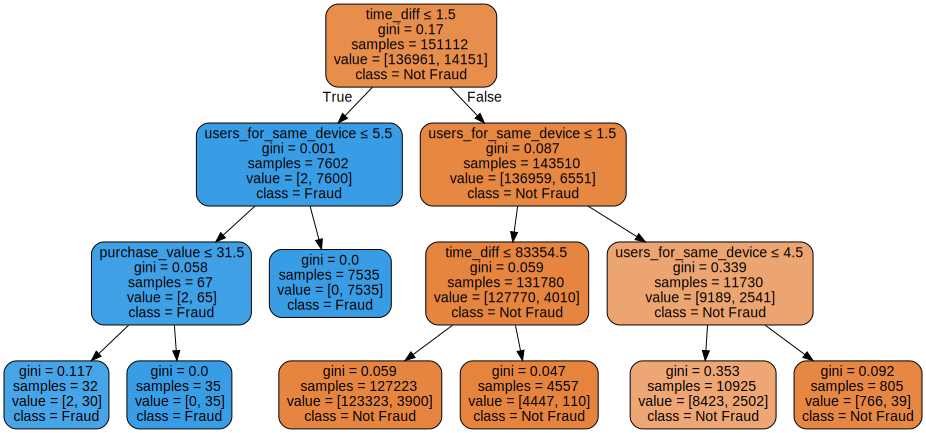

In [52]:
# Visualization
features=list(train_x.columns)
targets=['Not Fraud','Fraud']
dot_data=tree.export_graphviz(clf,out_file=None,feature_names=features,class_names=targets,
                             filled=True,rounded=True,special_characters=True,)
graph=graphviz.Source(dot_data)
graph

In [53]:
# Feature importance
importance = sorted(zip(features, clf.feature_importances_), key=lambda x:x[1], reverse=True)
for feature, val in importance:
    print('{0:10s} | {1:.5f}'.format(feature, val))

time_diff  | 0.94290
users_for_same_device | 0.05709
purchase_value | 0.00001
signup_day | 0.00000
signup_week | 0.00000
purchase_day | 0.00000
purchase_week | 0.00000
source     | 0.00000
browser    | 0.00000
sex        | 0.00000
age        | 0.00000
country    | 0.00000
users_for_same_ip | 0.00000


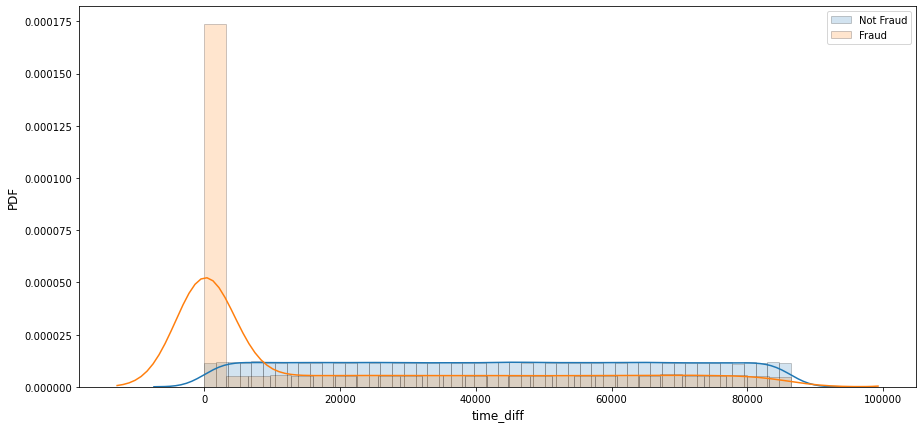

In [54]:
# Visualization
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
fig, ax = plt.subplots(figsize=(15, 7))
sns.distplot(subset[subset['class']==0]['time_diff'], 
             label='Not Fraud', ax=ax, hist_kws=hist_kws)
sns.distplot(subset[subset['class']==1]['time_diff'], 
             label='Fraud', ax=ax, hist_kws=hist_kws)
ax.set_xlabel('time_diff', fontsize=12)
ax.set_ylabel('PDF', fontsize=12)
ax.legend()
plt.show()

## Additional Analysis - Similarity

In [82]:
from sklearn.preprocessing import normalize
song = pd.read_json('E:/Collection_DS_takehome_challenges/Data/song.json')
song.head()

,id,user_id,user_state,user_sign_up_date,song_played,time_played
0,GOQMMKSQQH,122,Louisiana,2015-05-16,Hey Jude,2015-06-11 21:51:35
1,HWKKBQKNWI,3,Ohio,2015-05-01,We Can Work It Out,2015-06-06 16:49:19
2,DKQSXVNJDH,35,New Jersey,2015-05-04,Back In the U.S.S.R.,2015-06-14 02:11:29
3,HLHRIDQTUW,126,Illinois,2015-05-16,P.s. I Love You,2015-06-08 12:26:10
4,SUKJCSBCYW,6,New Jersey,2015-05-01,Sgt. Pepper's Lonely Hearts Club Band,2015-06-28 14:57:00


In [83]:
# Step 1: build the User matrix
song_user = song.groupby(['song_played', 'user_id'])['id'].count().unstack(fill_value=0)
song_user = (song_user > 0).astype(int)
print(song_user)

user_id                              1    2    3    4    5    6    7    8    \
song_played                                                                   
A Day In The Life                      0    0    1    1    0    1    0    0   
A Hard Day's Night                     0    0    0    0    0    1    0    0   
A Saturday Club Xmas/Crimble Medley    0    0    0    0    0    0    0    0   
ANYTIME AT ALL                         0    0    0    0    0    0    0    0   
Across The Universe                    0    0    0    1    0    0    0    0   
...                                  ...  ...  ...  ...  ...  ...  ...  ...   
YOUR MOTHER SHOULD KNOW                0    0    0    0    0    0    0    0   
Yellow Submarine                       0    0    0    0    0    0    1    0   
Yesterday                              1    1    0    0    0    0    0    0   
You Never Give Me Your Money           0    1    0    0    0    0    0    0   
You're Going To Lose That Girl         0    0    0  

In [84]:
# Step 2: build user-user similarity matrix
song_user_norm = normalize(song_user, axis=1)  # normalize the song-user matrix
similarity = np.dot(song_user_norm, song_user_norm.T)  # calculate the similarity matrix
similarity_df = pd.DataFrame(similarity, index=song_user.index, columns=song_user.index)

similarity_df.head()

song_played,A Day In The Life,A Hard Day's Night,A Saturday Club Xmas/Crimble Medley,ANYTIME AT ALL,Across The Universe,All My Loving,All You Need Is Love,And Your Bird Can Sing,BAD BOY,Baby You're A Rich Man,...,We Can Work It Out,When I'm 64,While My Guitar Gently Weeps,Wild Honey Pie,With a Little Help From My Friends,YOUR MOTHER SHOULD KNOW,Yellow Submarine,Yesterday,You Never Give Me Your Money,You're Going To Lose That Girl
song_played,,,,,,,,,,,,,,,,,,,,,
A Day In The Life,1.000000,0.263117,0.138675,0.14825,0.131559,0.299572,0.294174,0.098058,0.228802,0.200160,...,0.525213,0.113228,0.585429,0.278503,0.539411,0.087706,0.328897,0.377141,0.163430,0.0
A Hard Day's Night,0.263117,1.000000,0.000000,0.00000,0.100000,0.146385,0.111803,0.000000,0.000000,0.091287,...,0.305788,0.129099,0.266996,0.000000,0.157027,0.000000,0.050000,0.215003,0.074536,0.0
A Saturday Club Xmas/Crimble Medley,0.138675,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.161165,0.000000,0.000000,0.182574,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
ANYTIME AT ALL,0.148250,0.000000,0.000000,1.00000,0.000000,0.164957,0.094491,0.125988,0.000000,0.000000,...,0.172292,0.000000,0.188044,0.097590,0.176950,0.000000,0.000000,0.103835,0.000000,0.0
Across The Universe,0.131559,0.100000,0.000000,0.00000,1.000000,0.097590,0.000000,0.000000,0.000000,0.000000,...,0.101929,0.000000,0.133498,0.000000,0.104685,0.000000,0.000000,0.061430,0.000000,0.0


In [85]:
# Step 3: find the top-k most similar users
def find_topk(song, similarity, k):
    df = similarity.loc[song].sort_values(ascending=False)[1:k + 1].reset_index()
    df = df.rename(columns={'song_played': 'Song', song: 'Similarity'})
    
    return df

In [86]:
# Example: find the top 10 similar song for 'A Day In The Life'
df = find_topk(song='A Day In The Life', similarity=similarity_df, k=10)
df

,Song,Similarity
0,Revolution,0.710186
1,Come Together,0.696557
2,Get Back,0.676128
3,Hello Goodbye,0.617065
4,Back In the U.S.S.R.,0.614700
5,Let It Be,0.601105
6,Hey Jude,0.599145
7,While My Guitar Gently Weeps,0.585429
8,Lucy In The Sky With Diamonds,0.577453
9,Here Comes The Sun,0.561283


# Additional Analysis - Isolation Forest (Unsupervised) - Anomaly Detection

There are different methods for unsupervised anomaly detection, such as Isolation Forest, One-Class SVM, DBSCAN and so on.

Here, for simplicity, only DBSCAN method with default parameters is implemented.

In [88]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest

In [90]:
# normalize the data
x = data[['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 'source', 
           'browser', 'sex', 'age', 'country', 'time_diff', 'users_for_same_device', 'users_for_same_ip']]
scaler = StandardScaler()
norm_x = scaler.fit_transform(x)

In [91]:
# apply PCA
pca = PCA(n_components=2, random_state=42)
pca_x = pca.fit_transform(norm_x)
print(pca_x)

[[ 0.71517171 -0.48245487]
 [-0.25359101  0.52329327]
 [ 6.1077966   1.66519037]
 ...
 [ 0.23931388 -0.48886524]
 [-1.15781081  1.15838822]
 [-1.10669786  0.11557989]]


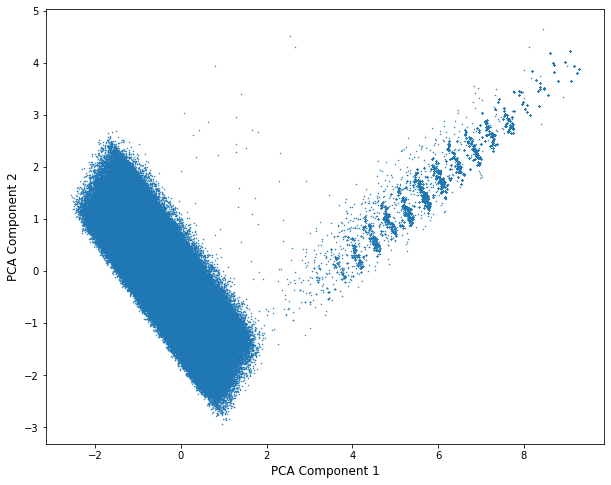

In [92]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(pca_x[:, 0], pca_x[:, 1], '.', markersize=1)
ax.set_xlabel('PCA Component 1', fontsize=12)
ax.set_ylabel('PCA Component 2', fontsize=12)
plt.show()

In [93]:
# build isolation forest model
forest = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.1, 
                         max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42)
forest = forest.fit(norm_x)
score = forest.decision_function(norm_x)
label = forest.predict(norm_x)

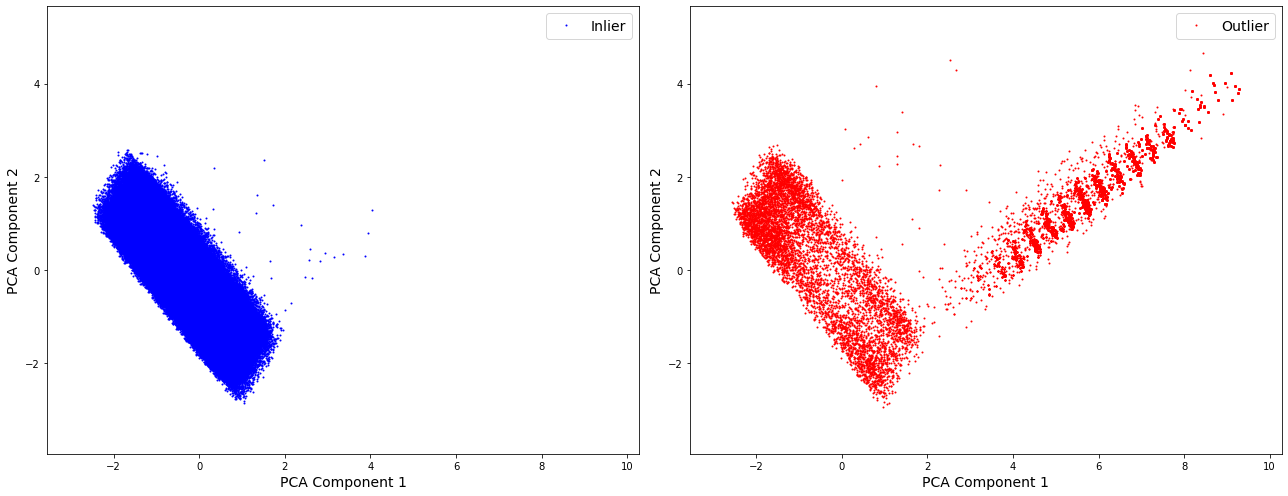

In [94]:
# visualization
inlier = pca_x[label == 1]
outlier = pca_x[label == -1]
xmin = pca_x[:, 0].min() - 1
xmax = pca_x[:, 0].max() + 1
ymin = pca_x[:, 1].min() - 1
ymax = pca_x[:, 1].max() + 1

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
ax[0].plot(inlier[:, 0], inlier[:, 1], 'b.', markersize=2, label='Inlier')
ax[0].set_xlabel('PCA Component 1', fontsize=14)
ax[0].set_ylabel('PCA Component 2', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].set_xlim([xmin, xmax])
ax[0].set_ylim([ymin, ymax])
ax[1].plot(outlier[:, 0], outlier[:, 1], 'r.', markersize=2, label='Outlier')
ax[1].set_xlabel('PCA Component 1', fontsize=14)
ax[1].set_ylabel('PCA Component 2', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].set_xlim([xmin, xmax])
ax[1].set_ylim([ymin, ymax])
plt.tight_layout()
plt.show()